# Triplet Trading Strategy

In [1]:
#packages
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_coint_rank
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.stats.diagnostic import het_goldfeldquandt
import warnings
import seaborn as sns
import scipy.stats as stats
warnings.filterwarnings('ignore')

### Data inspection

We resample our data to a weekly time frame to lower the frequency of trades.
Examining the chart, it seems that the cointergration relationship changed after May 2020, so we define a new start point at this cut date.

In [ ]:
# Load data from the "Clean" sheet
file_path = r"C:\Users\shoti\code\triplet_trading\Data_DDI.xlsx"
prices = pd.read_excel(file_path, sheet_name='clean_data')
prices.set_index('Date', inplace=True) #setting date as index

# resampling to weekly data as daily prices are very noisy
weekly_prices = prices.resample('W').last()
weekly_prices = weekly_prices[['Brent', 'Dubai', 'WTI']]

#Slitting data into training and testing samples
split_index = int(len(weekly_prices) * 0.7) #index for 70/30 split
train = weekly_prices.iloc[:split_index].dropna() #70% training
test = weekly_prices.iloc[split_index:].dropna() #30% testing

weekly_prices.plot(figsize=(12,4))
plt.title('Weekly Prices from 2019 to 2024');
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Data_DDI.xlsx'

### Unit roots

We perform ADF test on training sample to see if 3 time series contains unit roots.
Based on output mainly the T-stat and and high p-value we cannot reject the null hypothesis thus series are cointegrated.
Which is also intuitive since these are price processes, and such processes are normally known to be non-stationary.




In [ ]:
adf_brent = adfuller(train['Brent'])
adf_wti = adfuller(train['WTI'])
adf_dubai = adfuller(train['Dubai'])

# Create a DataFrame to store the results of ADF tests
results = pd.DataFrame({
    'Metric': ['Test Statistic', 'p-value', '# Lags Used', '# Observations Used', 'Critical Value (1%)'],
    'Brent': [adf_brent[0], adf_brent[1], adf_brent[2], adf_brent[3], adf_brent[4]['1%']],
    'WTI': [adf_wti[0], adf_wti[1], adf_wti[2], adf_wti[3], adf_wti[4]['1%']],
    'Dubai': [adf_dubai[0], adf_dubai[1], adf_dubai[2], adf_dubai[3], adf_dubai[4]['1%']]
})

results

,Metric,Brent,WTI,Dubai
0,Test Statistic,-0.547435,-0.418030,-0.698511
1,p-value,0.882423,0.907045,0.847135
2,# Lags Used,3.000000,4.000000,3.000000
3,# Observations Used,179.000000,178.000000,179.000000
4,Critical Value (1%),-3.467420,-3.467632,-3.467420


We differentiate the series to test again for ADF to find if unit root persists.
The ADF test shows stationarity after differentiating the series once.
Meaning the series contained unit root of order 1.





In [ ]:
differentiated_df = train.diff().dropna()
adf_brent_diff = adfuller(differentiated_df['Brent'])
adf_wti_diff = adfuller(differentiated_df['WTI'])
adf_dubai_diff = adfuller(differentiated_df['Dubai'])

# results from differentiated series
diff_results = pd.DataFrame({
    'Metric': ['Test Statistic', 'p-value', '# Lags Used', '# Observations Used', 'Critical Value (1%)'],
    'Brent': [adf_brent_diff[0], adf_brent_diff[1], adf_brent_diff[2], adf_brent_diff[3], adf_brent_diff[4]['1%']],
    'WTI': [adf_wti_diff[0], adf_wti_diff[1], adf_wti_diff[2], adf_wti_diff[3], adf_wti_diff[4]['1%']],
    'Dubai': [adf_dubai_diff[0], adf_dubai_diff[1], adf_dubai_diff[2], adf_dubai_diff[3], adf_dubai_diff[4]['1%']]
})

diff_results

,Metric,Brent,WTI,Dubai
0,Test Statistic,-6.448306e+00,-6.169263e+00,-6.350859e+00
1,p-value,1.545978e-08,6.868516e-08,2.613083e-08
2,# Lags Used,2.000000e+00,3.000000e+00,2.000000e+00
3,# Observations Used,1.790000e+02,1.780000e+02,1.790000e+02
4,Critical Value (1%),-3.467420e+00,-3.467632e+00,-3.467420e+00


<Axes: title={'center': 'Differentiated series'}, xlabel='Date'>

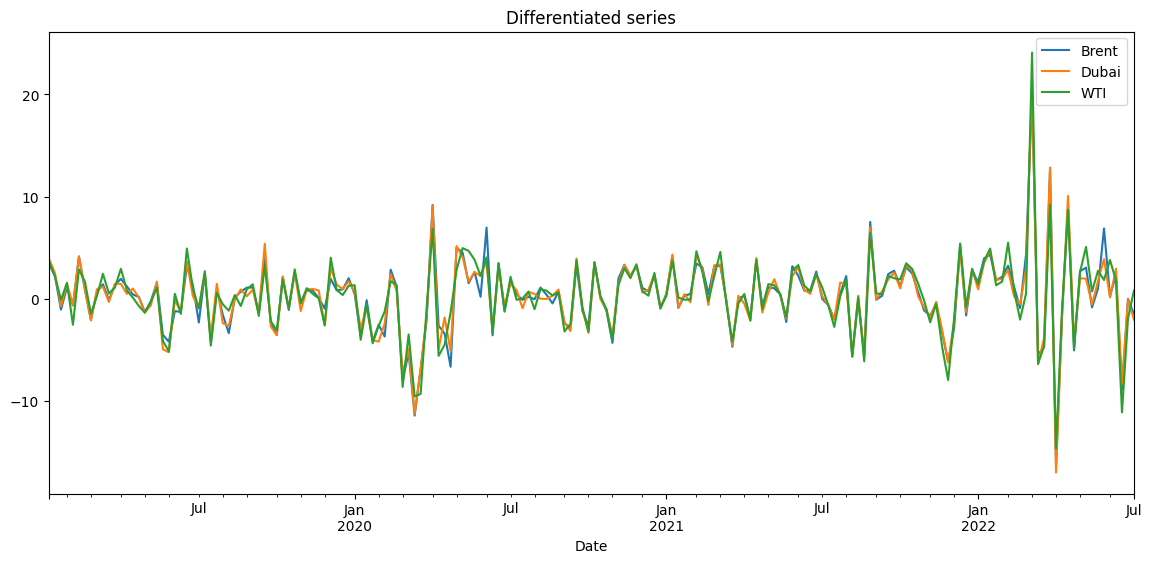

In [ ]:
differentiated_df.plot(figsize=(14, 6), title='Differentiated series')

In all cases, the KPSS test statistics are less than the critical values at the 10% significance level.
That means we fail to reject the null hypothesis of stationarity for both the constant and trend models.
This suggests that the differentiated series for Brent, WTI, and Dubai are stationary around a constant and around a deterministic trend.


In [ ]:
#Testing KPSS to find which type of stationary our differentiated process is
print(sm.tsa.stattools.kpss(differentiated_df['Brent'], regression='c'))
print(sm.tsa.stattools.kpss(differentiated_df['WTI'], regression='c'))
print(sm.tsa.stattools.kpss(differentiated_df['Dubai'], regression='c'))
print(sm.tsa.stattools.kpss(differentiated_df['Brent'], regression='ct'))
print(sm.tsa.stattools.kpss(differentiated_df['WTI'], regression='ct'))
print(sm.tsa.stattools.kpss(differentiated_df['Dubai'], regression='ct'))

(np.float64(0.2636842911816321), np.float64(0.1), 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(np.float64(0.20464104191406346), np.float64(0.1), 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(np.float64(0.2360234295918183), np.float64(0.1), 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(np.float64(0.05907065070175985), np.float64(0.1), 5, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(np.float64(0.05180201753008821), np.float64(0.1), 5, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})
(np.float64(0.0598954810290897), np.float64(0.1), 5, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


### Johansen Test

As information criteria, we chose BIC to stay away from overfitting and to find the optimal lag for our VAR that can be used in Johansen Test.

The optimal lag is calculated using the Hannan-Quinn Information Criterion (HQIC):

$$
\text{HQIC} = -2 \ln(L) + 2k \ln(\ln(T))
$$

where L is the likelihood of the model, k is the number of parameters, and T is the number of observations.

We then found the number of cointegrating relationships using the Johansen Test and the trace method to find the trace statistic:

$$
\text{Trace statistic} = -T \sum_{i=r+1}^{p} \ln(1 - \lambda_i)
$$

where
T is the number of observations, λ are the eigenvalues, and p is the number of variables.

Fially, the VECM (Vector Error Correction Model) is used to capture both short-term dynamics and long-term relationships.

In [ ]:
#Determining optimal VAR
model = VAR(differentiated_df)
optimal_lag = model.select_order(maxlags=15).hqic
print('Appropriate lag order is', optimal_lag)

#Determining rank through Johansen
rank_test = select_coint_rank(train, det_order=1, k_ar_diff=optimal_lag-1, method = "trace", signif = 0.01)
print('Appropriate cointegration rank is', rank_test.rank)

#Fitting VCEM
vecm = VECM(train, k_ar_diff=optimal_lag-1, coint_rank=rank_test.rank, deterministic='ci')
vecm_fit = vecm.fit()
alpha = vecm_fit.alpha
beta = vecm_fit.beta
const = vecm_fit.const_coint

Appropriate lag order is 4
Appropriate cointegration rank is 1


From the VECM we can extract the coefficients that describe the dynamics of the realtionships of the data:

*   **Alpha**: The speed at which the variables return to equilibrium after a deviation
*   **Beta**: The long-term equilibrium relationships between the variables
* **Const**: The constant shift in the cointegration relationship

In [ ]:
# pulling coefficients from VECM
alpha = vecm_fit.alpha
beta = vecm_fit.beta
const = vecm_fit.const_coint

In [ ]:
const = np.squeeze(const) # to ensure const can be broadcast correctly
beta = beta.flatten() # to ensure beta is 1-dimensional

# To ensure same shape of weekly_prices after running cell again
if 'spread' in weekly_prices.columns:
    weekly_prices = weekly_prices.drop(columns=['spread'])

entire_spread = np.dot(weekly_prices.values, beta) + const
weekly_prices['spread'] = entire_spread

# Calculate the spread for the training sample
# To ensure same shape of train after running cell again
if 'spread' in train.columns:
    train = train.drop(columns=['spread'])

training_spread = np.dot(train.values, beta) + const
train['spread'] = training_spread

# ADF shows stationarity in spread in training sample
adfuller_result = adfuller(train['spread'])
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')

ADF Statistic: -4.592609864068111
p-value: 0.0001332821287399227


Spread Standard Deviation: 0.7808771789395297


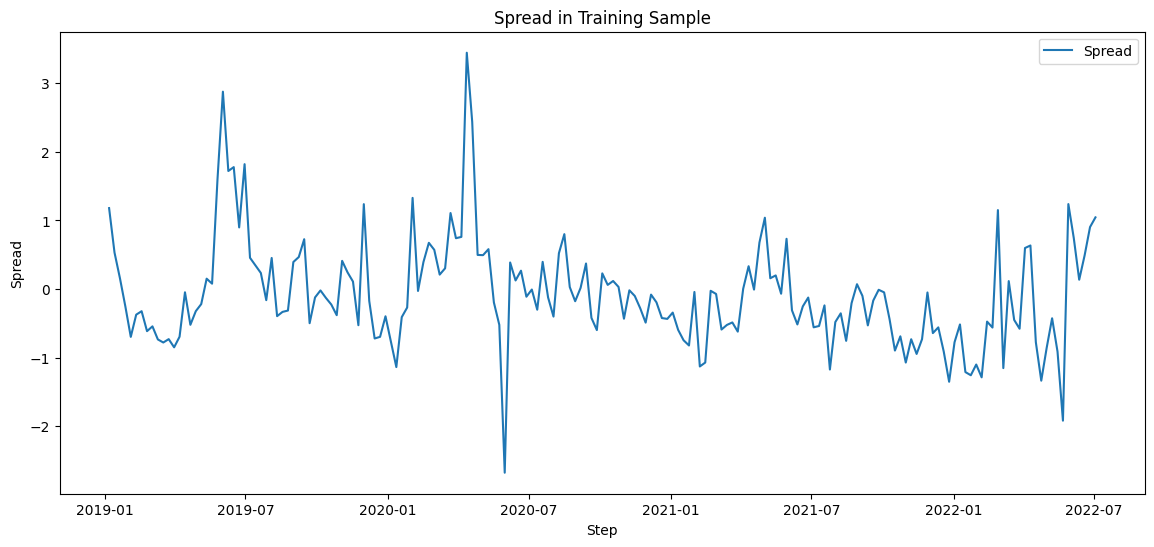

In [ ]:
# Plotting the spread for the training sample
plt.figure(figsize=(14, 6))
plt.plot(train['spread'], label='Spread')
plt.title('Spread in Training Sample')
plt.xlabel('Step')
plt.ylabel('Spread')
plt.legend()

# Calculate standard deviation of the spread
spread_std = train['spread'].std()
print(f'Spread Standard Deviation: {spread_std}')

In [ ]:
# SETTING UP THE PORTFOLIOS
const = np.squeeze(const)

Brent = weekly_prices['Brent']
WTI = weekly_prices['WTI']
Dubai = weekly_prices['Dubai']
crackS = beta[0] * Brent + beta[1] * Dubai + beta[2] * WTI + const
# # this is a dynamic flag that tells me whether the position is closed (=0) or open (=1)
flag_position = 0
fees = 0.002

crackS_std = np.std(train['spread'])
openingDateList = []
closingDateList = []
IS_training_days = len(train)
OOS_days = len(test)
returnPairsTrading = np.zeros(shape=(len(test),1))



for i in range(int(OOS_days)):
  today = IS_training_days +i
  if flag_position == 0:
    if abs(crackS[today]) >= 1 * crackS_std:
      flag_position = 1
      openingDateList.append(crackS.index[today])
      V_S = abs(beta[0] * Brent[today]) + abs(beta[1] * WTI[today]) + abs(beta[2] * Dubai[today])
      returnPairsTrading[i] = crackS[today] * (crackS[today] - crackS[today - 1]) / V_S - fees * abs(crackS[today] - crackS[today - 1])
  else:
    if np.sign(crackS[today]*crackS[today-1]) == -1:
      flag_position = 0
      closingDateList.append(crackS.index[today])
      returnPairsTrading[i] = 0
    else:
      flag_position = 1
      returnPairsTrading[i] = crackS[today]*(crackS[today]-crackS[today-1])/V_S -fees*abs(crackS[today]-crackS[today-1])


equity_curve = 100 * np.cumprod(1 + returnPairsTrading)
overall_ret = np.prod(returnPairsTrading +1) -1
print(f'Overall Return: {overall_ret}')

Overall Return: 0.1251636122871942


Text(0.5, 1.0, 'Trading Strategy')

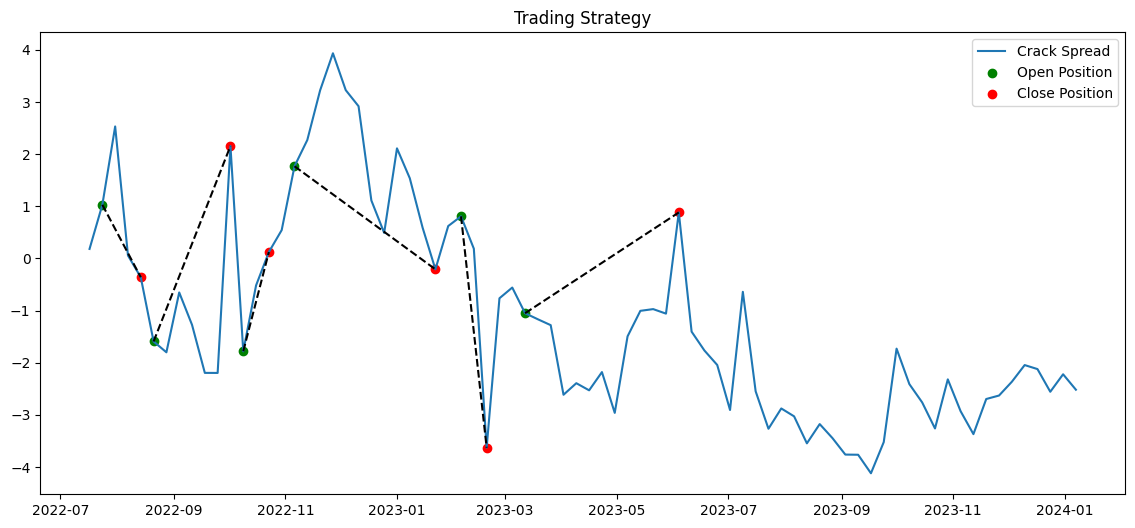

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(crackS[IS_training_days+1:], label='Crack Spread')
for i in range(len(closingDateList)):
    plt.scatter(openingDateList[i], crackS[openingDateList[i]], c='g', label='Open Position' if i == 0 else "")
    plt.scatter(closingDateList[i], crackS[closingDateList[i]], c='r', label='Close Position' if i == 0 else "")
    plt.plot([openingDateList[i], closingDateList[i]], [crackS[openingDateList[i]], crackS[closingDateList[i]]], c='k', linestyle='dashed')
plt.legend()
plt.title('Trading Strategy')

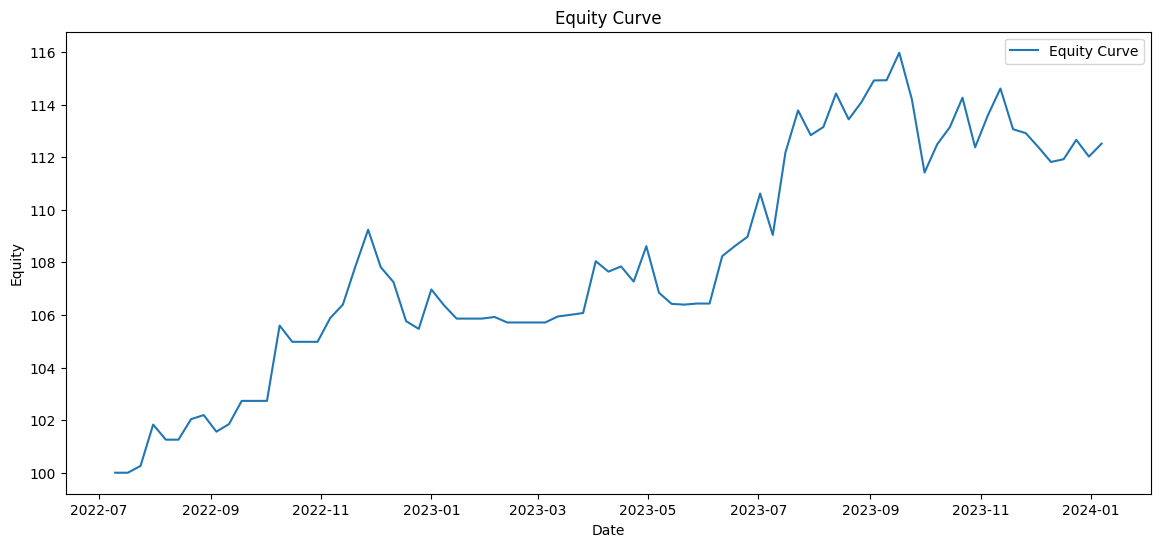

In [ ]:
# Plot the equity curve
plt.figure(figsize=(14, 6))
plt.plot(test.index, equity_curve, label='Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.show()

We want to check how much change in return we get for a change in fees and SD factor. This functon has both variables as an input and can then calculte the sensitivities.

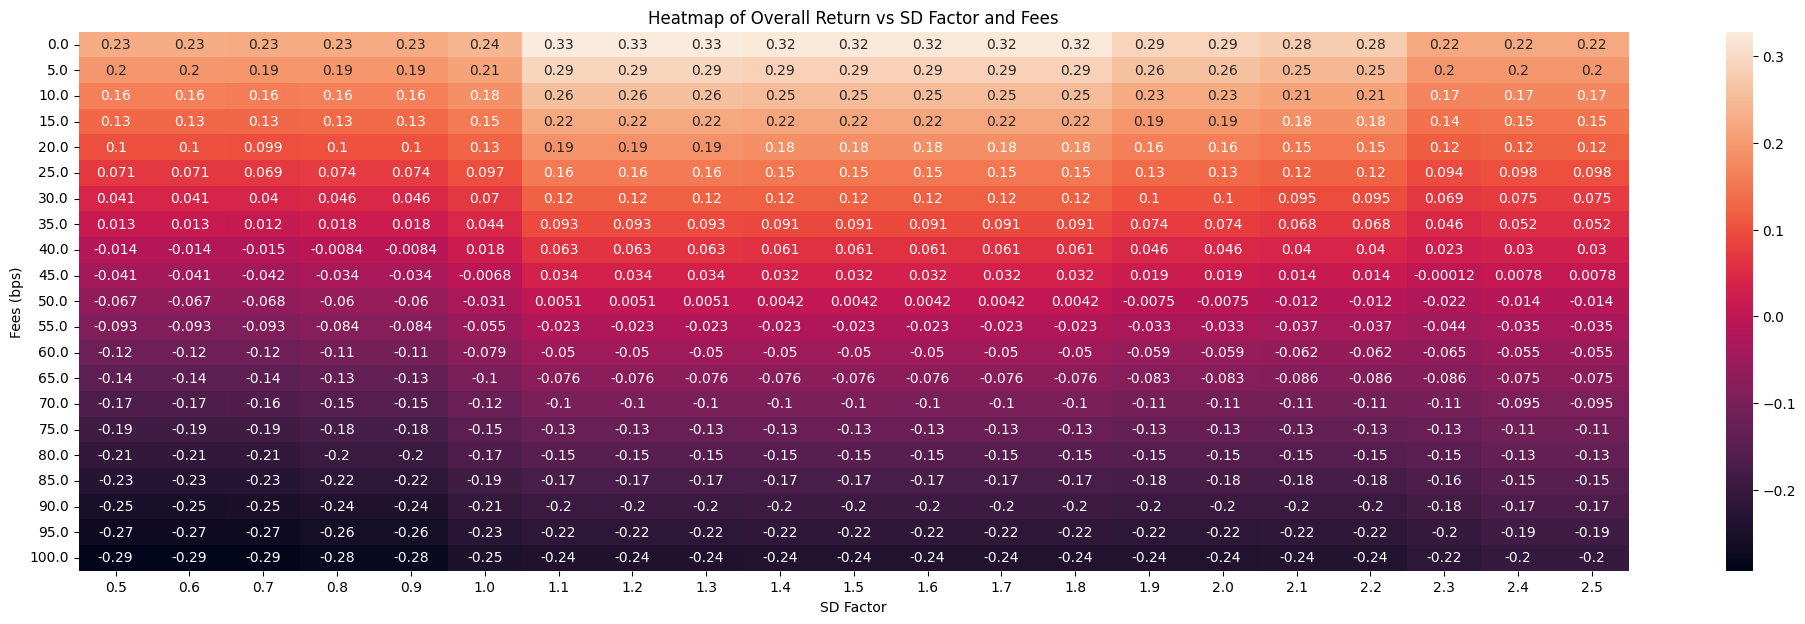

In [ ]:
# Function to calculate overall return given fees and SD_factor
def calculate_overall_return(fees, SD_factor=1):
    flag_position = 0
    IS_training_days = len(train)
    OOS_days = len(test)
    returnPairsTrading = np.zeros(shape=(len(test), 1))
    openingDateList.clear()
    closingDateList.clear()

    for i in range(int(OOS_days)):
        today = IS_training_days + i
        if flag_position == 0:
            if abs(crackS[today]) >= SD_factor * crackS_std:
                flag_position = 1
                openingDateList.append(crackS.index[today])
                V_S = abs(beta[0] * Brent[today]) + abs(beta[1] * WTI[today]) + abs(beta[2] * Dubai[today])
                returnPairsTrading[i] = crackS[today] * (crackS[today] - crackS[today - 1]) / V_S - fees * abs(crackS[today] - crackS[today - 1])
        else:
            if np.sign(crackS[today] * crackS[today - 1]) == -1:
                flag_position = 0
                closingDateList.append(crackS.index[today])
                returnPairsTrading[i] = 0
            else:
                flag_position = 1
                returnPairsTrading[i] = crackS[today] * (crackS[today] - crackS[today - 1]) / V_S - fees * abs(crackS[today] - crackS[today - 1])

    overall_ret = np.prod(returnPairsTrading + 1) - 1
    return overall_ret

# Parameters
fee_range = np.linspace(0, 0.01, 21)  # Simplified range for computational ease
SD_factor_range = np.linspace(0.5, 2.5, 21)
results = np.zeros((len(fee_range), len(SD_factor_range)))

# Calculating overall return for each combination of fees and SD factors
for i, fee in enumerate(fee_range):
    for j, SD_factor in enumerate(SD_factor_range):
        results[i, j] = calculate_overall_return(fee, SD_factor)

# Creating the heatmap
plt.figure(figsize=(25, 7))
sns.heatmap(results, xticklabels=np.round(SD_factor_range, 2), yticklabels=np.round(fee_range * 10000), annot=True)
plt.xlabel('SD Factor')
plt.ylabel('Fees (bps)')
plt.title('Heatmap of Overall Return vs SD Factor and Fees')
plt.show()